<a href="https://colab.research.google.com/github/schmuecker/transfer-learning/blob/main/computer_vision/classification_with_vgg/vgg_human_action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is HAR ?
- Human activity recognition, or HAR for short, is a broad field of study concerned with identifying the specific movement or action of a person based on sensor data. 
- Movements are often typical activities performed indoors, such as walking, talking, standing, and sitting

# Why it is important ?

- Human activity recognition plays a significant role in human-to-human interaction and interpersonal relations. 
- Because it provides information about the identity of a person, their personality, and psychological state, it is difficult to extract. 
- The human ability to recognize another person’s activities is one of the main subjects of study of the scientific areas of computer vision and machine learning. As a result of this research, many applications, including video surveillance systems, human-computer interaction, and robotics for human behavior characterization, require a multiple activity recognition system.

#  Here are some example:

![](https://user-images.githubusercontent.com/11255376/71256359-d6ca1300-2373-11ea-812a-babb3b5b2ad5.gif)

![](https://learnopencv.com/wp-content/uploads/2021/07/yoga-poses.gif)

# What is VGG16?

- The VGG model, or VGGNet, that supports 16 layers is also referred to as VGG16, which is a convolutional neural network model proposed by A. Zisserman and K. Simonyan from the University of Oxford. These researchers published their model in the research paper titled, [“Very Deep Convolutional Networks for Large-Scale Image Recognition.”](https://arxiv.org/abs/1409.1556)

- The VGG16 model achieves almost 92.7% top-5 test accuracy in ImageNet. ImageNet is a dataset consisting of more than 14 million images belonging to nearly 1000 classes. Moreover, it was one of the most popular models submitted to ILSVRC-2014. It replaces the large kernel-sized filters with several 3×3 kernel-sized filters one after the other, thereby making significant improvements over AlexNet. The VGG16 model was trained using Nvidia Titan Black GPUs for multiple weeks.

- As mentioned above, the VGGNet-16 supports 16 layers and can classify images into 1000 object categories, including keyboard, animals, pencil, mouse, etc. Additionally, the model has an image input size of 224-by-224.  

# HAR using VGG16

### Import libraries

In [1]:
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 8.4 MB/s 
     |████████████████████████████████| 95 kB 4.0 MB/s 
     |████████████████████████████████| 212 kB 53.4 MB/s 
     |████████████████████████████████| 115 kB 51.0 MB/s 
     |████████████████████████████████| 163 kB 51.8 MB/s 
     |████████████████████████████████| 127 kB 52.0 MB/s 
     |████████████████████████████████| 115 kB 59.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
from datasets import load_dataset
from PIL import Image
from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

## Enable GPU

Make sure "GPU" is selected under Edit -> Notebook Settings -> Hardware Acceleration

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Downloading the dataset

In [4]:
dataset = load_dataset("Bingsu/Human_Action_Recognition")
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Bingsu___parquet/Bingsu--Human_Action_Recognition-8c4395446c1c9642/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 12600
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 5400
    })
})

In [39]:
classes = {
     0: 'calling',
     1: 'clapping',
     2: 'cycling',
     3: 'dancing',
     4: 'drinking',
     5: 'eating',
     6: 'fighting',
     7: 'hugging',
     8: 'laughing',
     9: 'listening_to_music',
     10: 'running',
     11: 'sitting',
     12: 'sleeping',
     13: 'texting',
     14: 'using_laptop',
}

# Creating a function to random take a image and display it with its label

In [62]:
def disp():
    num = random.randint(1,10000)
    testImage = dataset['train'][num]['image']
    print(testImage)
    plt.imshow(testImage)
    plt.title(classes[dataset['train'][num]['labels']])

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=324x155 at 0x7F406EA15690>


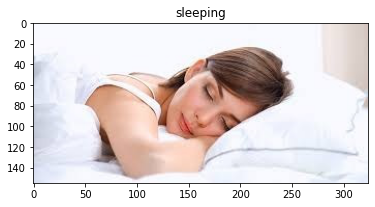

In [41]:
disp()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225 at 0x7F406E968E10>


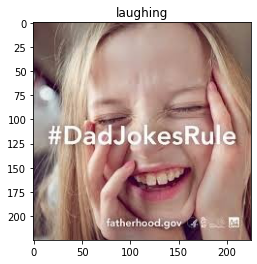

In [42]:
disp()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=194x259 at 0x7F406E8F42D0>


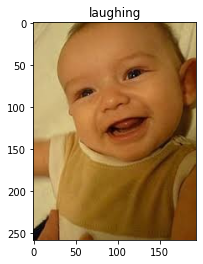

In [43]:
disp()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=265x190 at 0x7F406E876950>


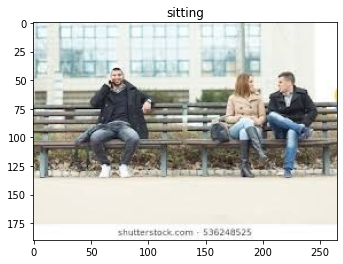

In [44]:
disp()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=428x118 at 0x7F406E8D59D0>


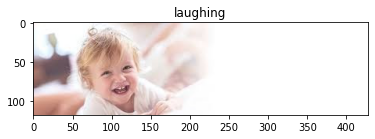

In [45]:
disp()

# Processing data

In [11]:
X_train, y_train = [], []

for a in dataset['train']:
  image, labels = a['image'], a['labels']
  img = np.asarray(image.resize((160,160)), dtype=np.float32)
  X_train.append(img)
  y_train.append(labels)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train.shape, y_train.shape

((12600, 160, 160, 3), (12600,))

In [12]:
X_train.shape, y_train.shape

((12600, 160, 160, 3), (12600,))

In [13]:
X_test = []

for a in dataset['test']:
  image = a['image']
  img = np.asarray(image.resize((160,160)), dtype=np.float32)
  X_test.append(img)

X_test = np.array(X_test)

In [14]:
X_test.shape

(5400, 160, 160, 3)

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 80 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('loss') < 0.3) and (logs.get('accuracy') > 0.8):

      # Stop if threshold is met
      print("\nLoss is lower than 0.3 and accuracy higher than 0.8. Cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [16]:
vgg_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(160,160,3),
                   pooling='avg',classes=15,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

vgg_model.add(pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(15, activation='softmax'))

58889256/58889256 [==============================] - 3s 0us/step


In [17]:
vgg_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [18]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14,985,039
Trainable params: 270,351
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
history = vgg_model.fit(X_train, y_train, epochs = 100, callbacks=[callbacks])

Epoch 1/100
394/394 [==============================] - 45s 88ms/step - loss: 2.2651 - accuracy: 0.4427
Epoch 2/100
394/394 [==============================] - 34s 86ms/step - loss: 1.2245 - accuracy: 0.6071
Epoch 3/100
394/394 [==============================] - 33s 85ms/step - loss: 0.9466 - accuracy: 0.6925
Epoch 4/100
394/394 [==============================] - 34s 86ms/step - loss: 0.7188 - accuracy: 0.7650
Epoch 5/100
394/394 [==============================] - 33s 85ms/step - loss: 0.5247 - accuracy: 0.8288
Epoch 6/100
394/394 [==============================] - 34s 85ms/step - loss: 0.3713 - accuracy: 0.8813
Epoch 7/100
394/394 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.9183
Loss is lower than 0.3 and accuracy higher than 0.8. Cancelling training!
394/394 [==============================] - 34s 85ms/step - loss: 0.2624 - accuracy: 0.9183


In [20]:
vgg_model.save_weights("model.h5")

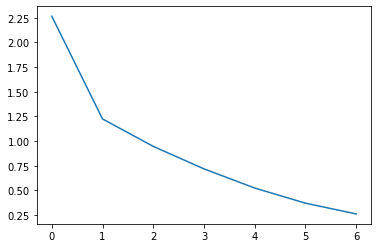

In [21]:
loss = history.history['loss']
plt.plot(loss)

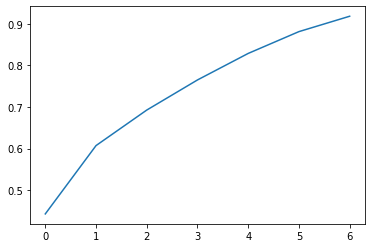

In [22]:
accu = history.history['accuracy']
plt.plot(accu)

# Custom Testing

In [69]:
# Function to predict

def test_predict():
    test_index = random.randint(1,len(X_test))
    result = vgg_model.predict(X_test[test_index].reshape(1,160,160,3))
    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", prediction)

    image = dataset['test'][test_index]['image']
    plt.imshow(image)
    plt.title(classes[prediction])

1/1 [==============================] - 0s 16ms/step
probability: 75.49245357513428%
Predicted class :  9


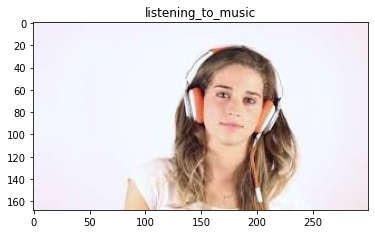

In [68]:
test_predict()

1/1 [==============================] - 0s 17ms/step
probability: 36.735999584198%
Predicted class :  0


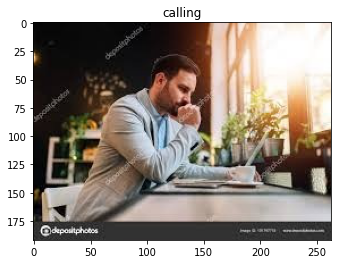

In [70]:
test_predict()

1/1 [==============================] - 0s 19ms/step
probability: 92.65996813774109%
Predicted class :  13


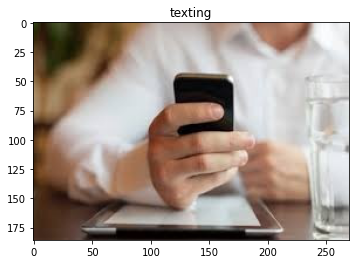

In [71]:
test_predict()

1/1 [==============================] - 0s 18ms/step
probability: 99.88118410110474%
Predicted class :  7


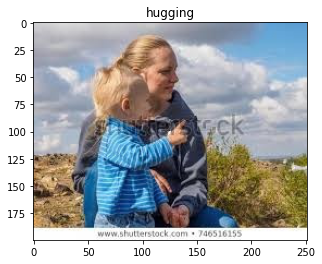

In [72]:
test_predict()

1/1 [==============================] - 0s 16ms/step
probability: 65.89324474334717%
Predicted class :  12


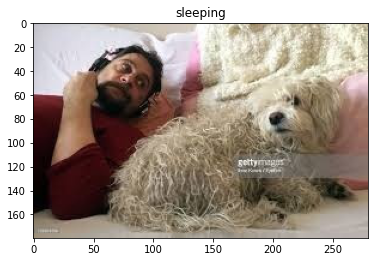

In [73]:
test_predict()